# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, ParameterGrid
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
taxi = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(taxi.info())
taxi

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
print('Монотонный:', taxi.index.is_monotonic)
print('Дубликаты:', taxi.index.duplicated().sum())

Монотонный: True
Дубликаты: 0


Данные не содержат пропусков и дубликатов. Индексы расположены в хронологическом порядке. Проведем ресемплирование с шагом 1 час.

In [5]:
taxi = taxi.resample('1H').sum()
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# 2. Анализ

In [6]:
taxi['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

In [7]:
def plot_timeline(data):
    plt.figure(figsize=(15, 4))
    data.plot(ax=plt.gca())
    plt.grid()
    plt.show()

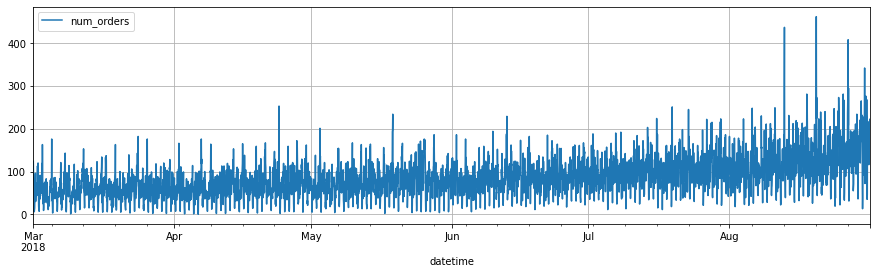

In [8]:
plot_timeline(taxi)

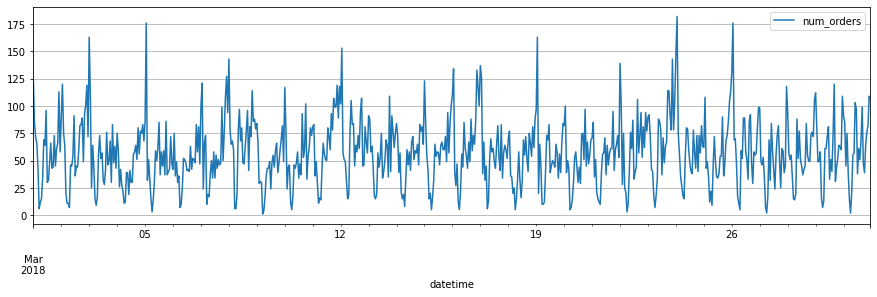

In [9]:
plot_timeline(taxi['2018-03-01':'2018-03-30'])

Обычные графики дают мало представления о закономерностях в данных. Посмотрим на тренды и сезонность

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matpl

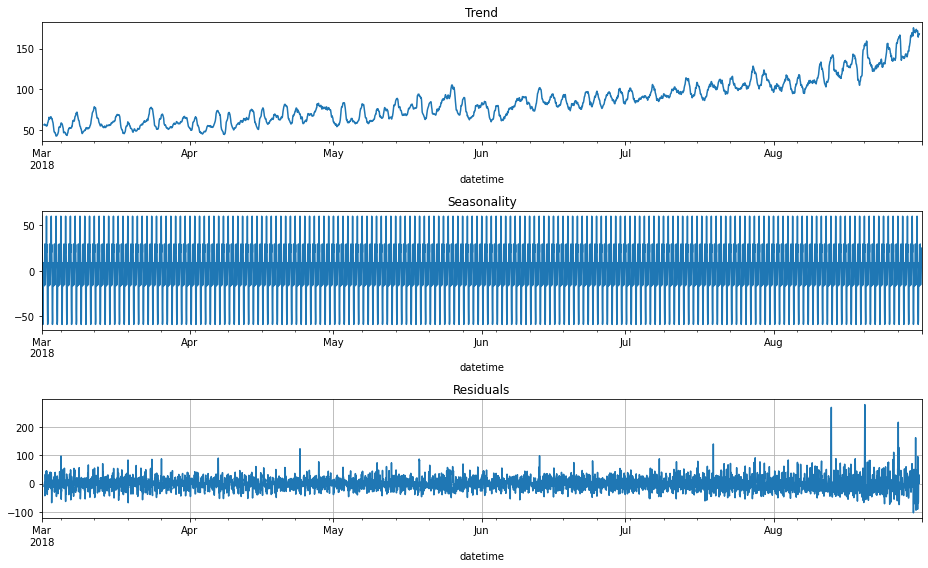

In [10]:
decomposed = seasonal_decompose(taxi['num_orders'])
plt.figure(figsize=(13, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.grid()

Виден тренд на увеличение кол-ва заказов. По всей видимости, мы наблюдаем рост сервиса. Выборка имеет длительность 6 месяцев, поэтому влияние времен года увидеть нельзя.  
Повторяющиеся значения можно оценить, если установить масштаб несколько дней

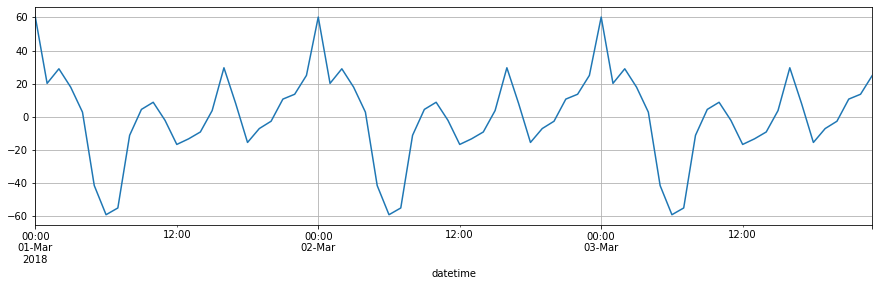

In [11]:
plot_timeline(decomposed.seasonal['2018-03-01':'2018-03-03'])

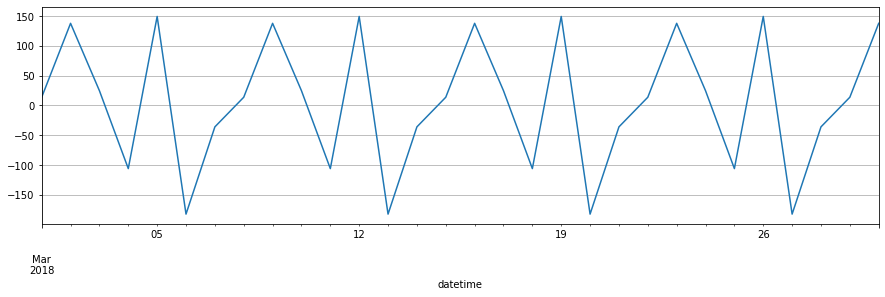

In [12]:
decomposed_d = seasonal_decompose(taxi['num_orders'].resample('1D').sum())
plot_timeline(decomposed_d.seasonal['2018-03-01':'2018-03-30'])

На графике остатков хорошо видны выбросы, которые не зависят от систематики. Удалим те строки, для которых значение остатка превышает 3 СКО.

In [13]:
print(decomposed.resid.mean())
print(decomposed.resid.std())

-0.008130312689734848
24.696895960143483


Введем общие признаки

In [14]:
taxi['month'] = taxi.index.month
taxi['day'] = taxi.index.day
taxi['dayofweek'] = taxi.index.dayofweek
taxi

,num_orders,month,day,dayofweek
datetime,,,,
2018-03-01 00:00:00,124,3,1,3
2018-03-01 01:00:00,85,3,1,3
2018-03-01 02:00:00,71,3,1,3
2018-03-01 03:00:00,66,3,1,3
2018-03-01 04:00:00,43,3,1,3
...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4
2018-08-31 20:00:00,154,8,31,4
2018-08-31 21:00:00,159,8,31,4


# 3. Обучение

Сразу выделим тестовую выборку, валидационную выделять не будем, воспользуемся кросс-валидацией

In [15]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
print('train:', train.shape)
print('test:', test.shape)

train: (3974, 4)
test: (442, 4)


Создадим заготовку таблицы для сравнения результатов

In [16]:
model_res = pd.DataFrame()
model_res.loc['required', 'RMSE'] = 48

Введем функцию расчета RMSE

In [17]:
def rmse(real, predict, title='', print_res=False, save_res=False):
    rmse = np.round(mean_squared_error(real, predict) ** 0.5, 2)
    if title and save_res:
        model_res.loc[title, 'RMSE'] = rmse
    if print_res:
        print(title+' RMSE', rmse)
    return rmse

In [18]:
rmse_score = make_scorer(rmse, greater_is_better=False)
scoring = {'RMSE': rmse_score}

Определим результат, достижимый прогнозированием медианного и предыдущего значения.

In [19]:
pred_median = np.ones(test['num_orders'].shape) * train['num_orders'].median()
pred_previous = test['num_orders'].shift(1, fill_value=train.iloc[-1,0])
rmse(test['num_orders'], pred_median, 'dummy median', True, True)
rmse(test['num_orders'], pred_previous, 'dummy previous', True, True)

dummy median RMSE 87.15
dummy previous RMSE 58.86


58.86

Прогнозирование предыдущего значения дает RMSE 50,03, что лишь немного недотягивает до требуемого значения 48.

Для дальнейшего подбора моделей введем функции:
- make_features - для создания признаков и разделения выборки на features и target 
- check_features - для проверки результата на валидационной выборке (10% от обучающей)
- grid_features - для перебора признаков
- grid_hparams - для перебора гиперпараметров
- plot_line и plot_heatmap - для отображения результатов в виде графика или тепловой карты

In [20]:
def plot_line(x, y, labels='', title='', xlabel=''):
    '''
    Функция выводит графики зависимости выбранных метрик исследуемой модели от значения гиперпараметра
    Входные параметры:
    - х - значения гиперпараметра
    - results - массив результатов
    - label - название результата (легенда линии)
    - title - название модели (подпись графика)
    - xlabel - название изменяемого гиперпараметра (подпись оси Х)
    - treshold - пороговое значение (прямая на линия на графике, не обязательный параметр)
    '''
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x, y, marker='.')
    ax.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

In [21]:
def plot_heatmap(x1, x2, y, title='', label=['','']):
    '''
    функция выводит график типа "heatmap" зависимости качества исследуемой модели от значений двух гиперпараметров
    х1 - значения гиперпараметра 1
    х2 - значения гиперпараметра 2
    y - значение метрики в виде одномерного массива (результат работы функции GridSearchCV.cv_results_['...'])
    title - название модели (подпись графика)
    label - массив с названиями двух гиперпараметров (подписи осей Х и Y)
    '''
    ysize = len(x1) if len(x1)<16 else 16
    xsize = len(x2) if len(x2)<16 else 16
    fig, ax = plt.subplots(figsize=(xsize,ysize))
    im = ax.imshow(y, cmap='coolwarm')
    plt.title(title)
    
    cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)

    ax.set_xticks(np.arange(len(x2)))
    ax.set_yticks(np.arange(-0.5,len(x1)))
    ax.set_xticklabels(x2)
    ax.set_yticklabels(x1)
    ax.set_xlabel(label[1])
    ax.set_ylabel(label[0])

    for i in range(len(x1)):
        for j in range(len(x2)):
            text = ax.text(j, i, y[i, j], ha="center", va="center", color="k", fontsize=8)
    plt.show()

In [22]:
def make_features(data, max_lag, rolling_mean_size):

    target = data['num_orders']
    features = data[['month','day','dayofweek']]

    for lag in range(1, max_lag + 1):
        features['lag_{}'.format(lag)] = target.shift(lag)

    features['rolling_mean'] = target.shift().rolling(rolling_mean_size).mean()
    
    features.dropna(inplace=True)
    target = target.loc[features.index]
    
    return features, target

In [23]:
def check_features(model, max_lag, rolling_mean_size):
    train_features, train_target = make_features(train, max_lag, rolling_mean_size)
    train_features, valid_features, train_target, valid_target = train_test_split(train_features, train_target, 
                                                                                  shuffle=False, test_size=0.1)
    model.fit(train_features, train_target)
    valid_prediction = model.predict(valid_features)
    return rmse(valid_target, valid_prediction)

In [24]:
def grid_features(model, lags, rollings, title='', save_res=False):
    
    # cоздаем прогрессбар для ощущения контроля за процессом
    prgBar = IntProgress(min=0, max=len(lags)*len(rollings)) 
    display(prgBar)
    
    res = np.zeros((len(lags), len(rollings)))
    for i in range(len(lags)):
        for j in range(len(rollings)):
            res[i,j] = check_features(model, lags[i], rollings[j])
            prgBar.value += 1
    plot_heatmap(lags, rollings, res, title='RMSE '+title, label=['lags','rollings'])
    
    print('Best RMSE:', res.min())
    best_idx = np.unravel_index(np.argmin(res, axis=None), res.shape)
    print('Best params: (%d, %d)' % (lags[best_idx[0]], rollings[best_idx[1]]))
    
    if title and save_res:
        model_res.loc[title,'RMSE'] = res.min()

In [25]:
def grid_hparams(model, params, features, target, title='', save_res=False):

    train_features, valid_features, train_target, valid_target = train_test_split(features, target, 
                                                                                  shuffle=False, test_size=0.1)
    res = []
    grid = ParameterGrid(params)
    
    # cоздаем прогрессбар для ощущения контроля за процессом
    prgBar = IntProgress(min=0, max=len(grid)) 
    display(prgBar)
    
    for g in grid:
        model.set_params(**g)
        model.fit(train_features, train_target)
        #train_prediction = model.predict(train_features)
        valid_prediction = model.predict(valid_features)
        res.append(rmse(valid_target, valid_prediction))
        prgBar.value += 1
    
    # графики
    params_values = list(params.values())
    params_keys = list(params.keys())
    # линия для одного параметра
    if len(params_keys)==1:
        plot_line(params_values[0], res, title='RMSE '+title, xlabel=params_keys[0])
    # хитмап для двух параметров
    elif len(params_keys)==2:
        len_p1 = len(params_values[0])
        len_p2 = len(params_values[1])
        res = np.reshape(res, (len_p1, len_p2))              
        plot_heatmap(params_values[0], params_values[1], res, title='RMSE '+title, label=params_keys)
    else:
        print('grid_hparams: can\'t plot result')
    
    # лучший результат
    print('Best RMSE:', np.min(res))
    best_idx = np.argmin(res)
    print('Best params:', grid[best_idx])    

    # запись лучшего результата
    if title and save_res:
        model_res.loc[title,'RMSE'] = np.min(res)

#### Линейная Регрессия

IntProgress(value=0, max=110)

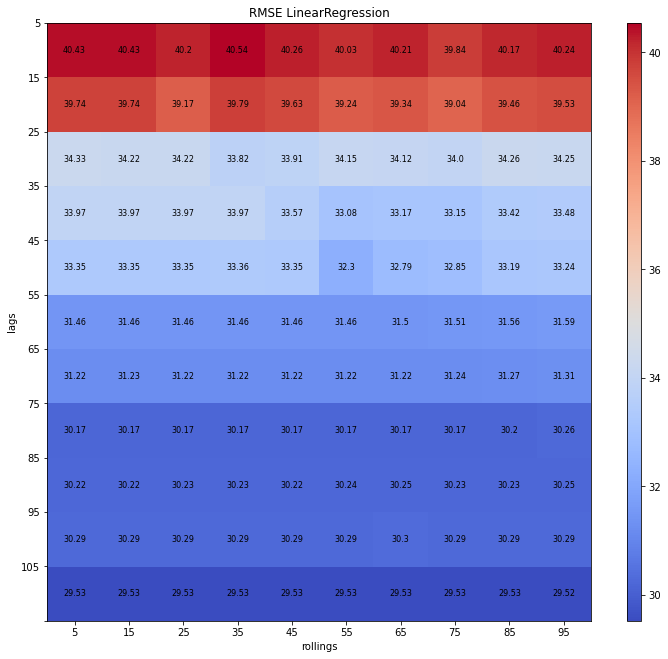

Best RMSE: 29.52
Best params: (105, 95)


In [26]:
model = LinearRegression()
lags = range(5,110,10)
rollings = range(5,100,10)
grid_features(model, lags, rollings, 'LinearRegression')

Линейная регрессия достигает лучшего результата при 65 лагах, а от размера окна сглаживания почти не зависит. Попробуем более точно подобрать параметры вблизи лучшего результата.

IntProgress(value=0, max=50)

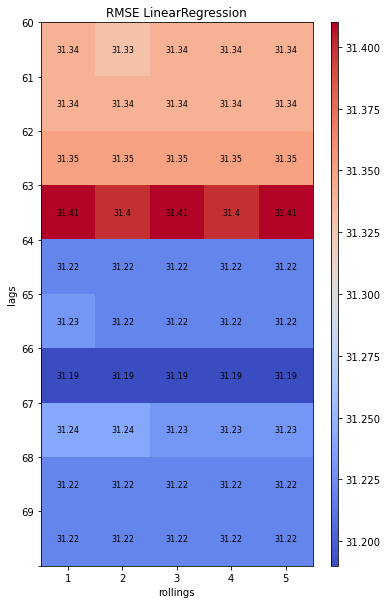

Best RMSE: 31.19
Best params: (66, 1)


In [27]:
model = LinearRegression()
lags = range(60,70)
rollings = range(1,6)
grid_features(model, lags, rollings, 'LinearRegression', True)

Улучшить не удалось. Лучший результат 30,7 получен при 65 лагах и фактически без сглаживания (окно сглаживания 1).

#### Лассо
Попробуем Лассо с теми же признаками

IntProgress(value=0, max=6)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269508.380053067, tolerance: 460.183095650938
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269688.6856691779, tolerance: 460.183095650938
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270451.97379879456, tolerance: 460.183095650938
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271

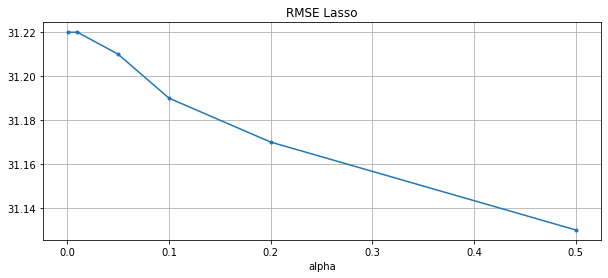

Best RMSE: 31.13
Best params: {'alpha': 0.5}


In [28]:
train_features, train_target = make_features(train, 65, 1)
model = Lasso()
params = {"alpha": [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]}
grid_hparams(model, params, train_features, train_target, 'Lasso', True)

Разница с линейной регрессией минимальная.

#### Дерево решений
Здесь и далее сначала будем определять лучший набор параметров для модели по умолчанию, затем подберем гиперпараметры модели.

IntProgress(value=0)

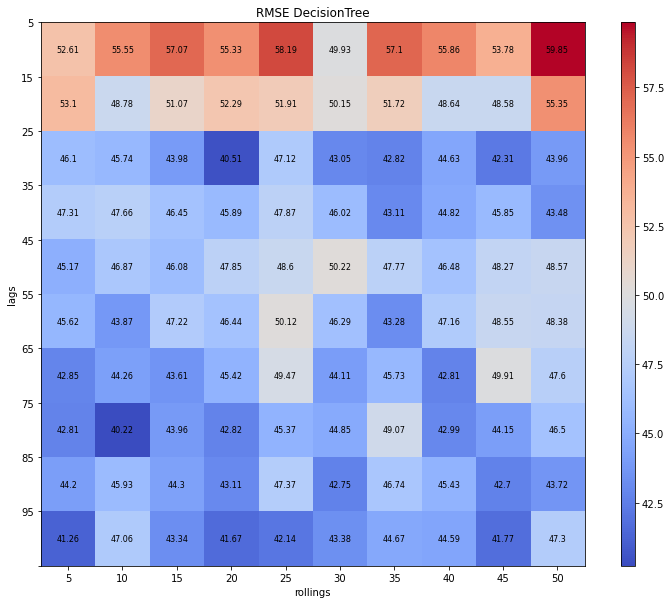

Best RMSE: 40.22
Best params: (75, 10)


In [29]:
model = DecisionTreeRegressor(random_state=123)
lags = range(5,100,10)
rollings = range(5,55,5)
grid_features(model, lags, rollings, 'DecisionTree')

IntProgress(value=0, max=135)

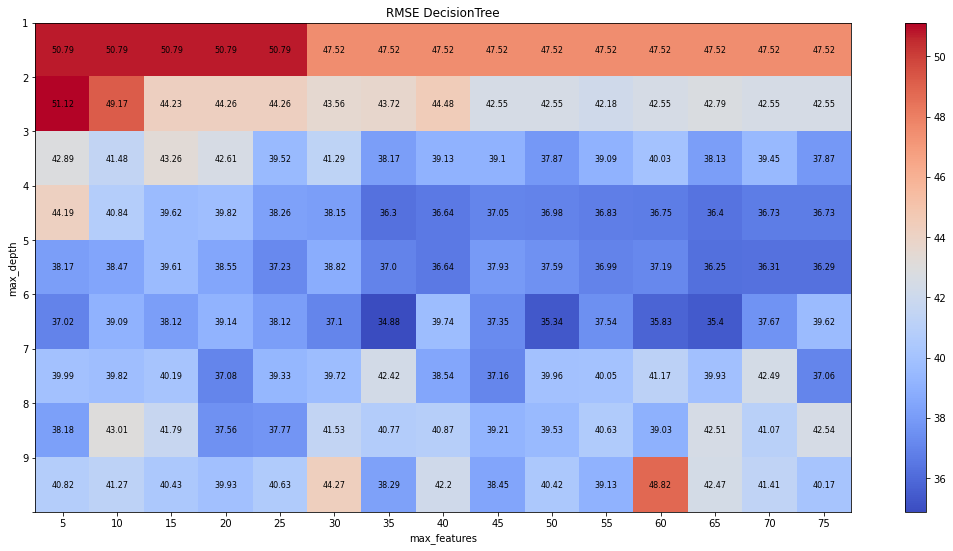

Best RMSE: 34.88
Best params: {'max_features': 35, 'max_depth': 6}


In [30]:
train_features, train_target = make_features(train, 75, 40)
model = DecisionTreeRegressor(random_state=123)
params = {"max_depth": range(1,10), "max_features": range(5,76,5)}
grid_hparams(model, params, train_features, train_target, 'DecisionTree', True)

Дерево решений уступает по точности линейной регрессии.

#### Случайный лес

IntProgress(value=0)

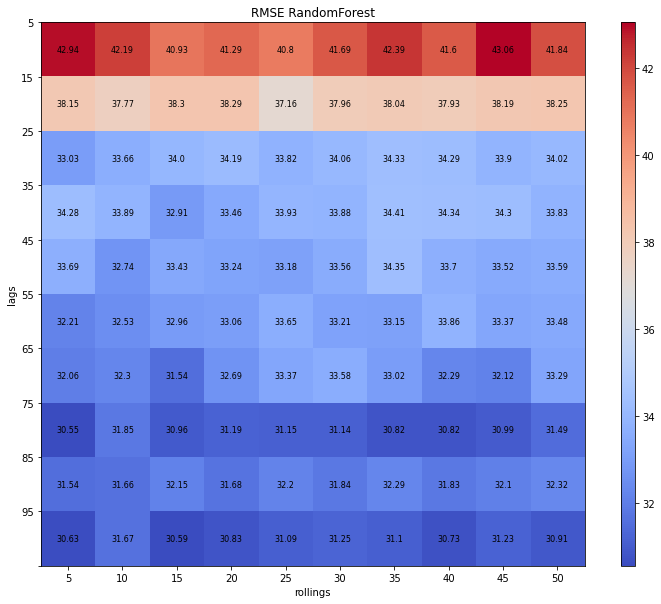

Best RMSE: 30.55
Best params: (75, 5)


In [31]:
model = RandomForestRegressor(n_estimators=20, random_state=123)
lags = range(5,100,10)
rollings = range(5,55,5)
grid_features(model, lags, rollings, 'RandomForest')

IntProgress(value=0, max=45)

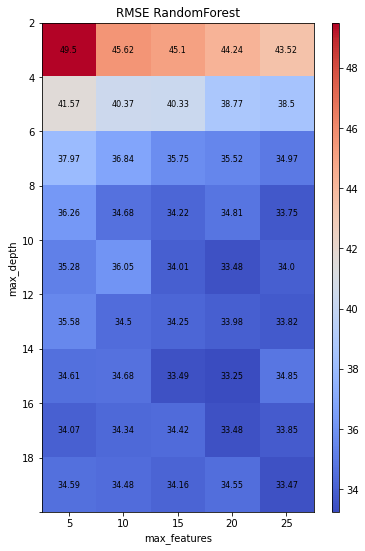

Best RMSE: 33.25
Best params: {'max_features': 20, 'max_depth': 14}


In [32]:
train_features, train_target = make_features(train, 25, 10)
model = RandomForestRegressor(n_estimators=10, random_state=123)
params = {"max_depth": range(2,20,2), "max_features": range(5,26,5)}
grid_hparams(model, params, train_features, train_target, 'RandomForest')

Признаки и гиперпараметры подобраны для быстрой модели из 20 деревьев. Посмотрим, удастся ли его улучшить при увеличении кол-ва деревьев.

IntProgress(value=0, max=5)

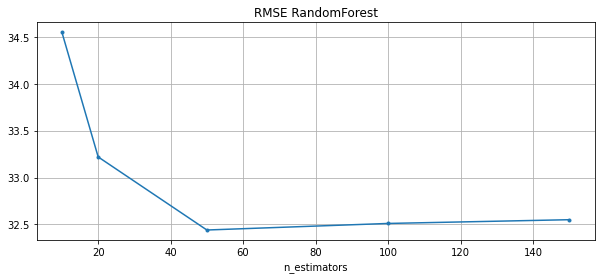

Best RMSE: 32.44
Best params: {'n_estimators': 50}


In [33]:
train_features, train_target = make_features(train, 25, 10)
model = RandomForestRegressor(max_depth=18, max_features=20, random_state=123)
params = {"n_estimators": [10, 20, 50, 100, 150]}
grid_hparams(model, params, train_features, train_target, 'RandomForest', True)

Результат лишь немного превосходит линейную регрессию.

#### Соседи

IntProgress(value=0)

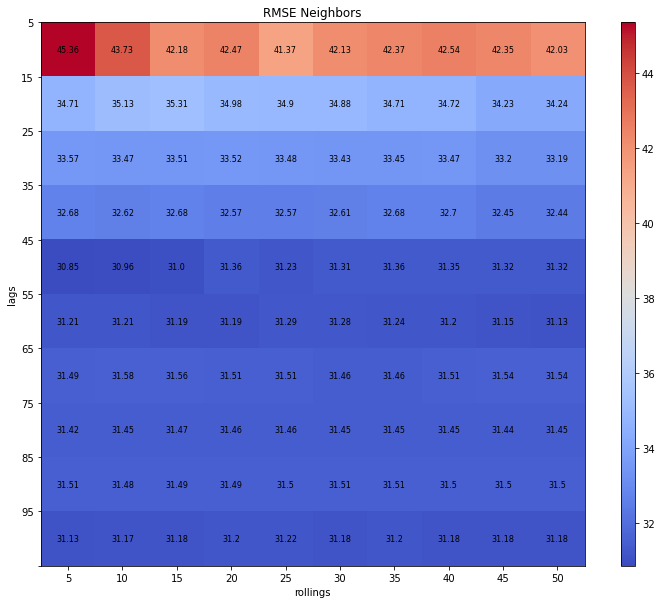

Best RMSE: 30.85
Best params: (45, 5)


In [34]:
model = KNeighborsRegressor()
lags = range(5,100,10)
rollings = range(5,55,5)
grid_features(model, lags, rollings, 'Neighbors')

IntProgress(value=0, max=18)

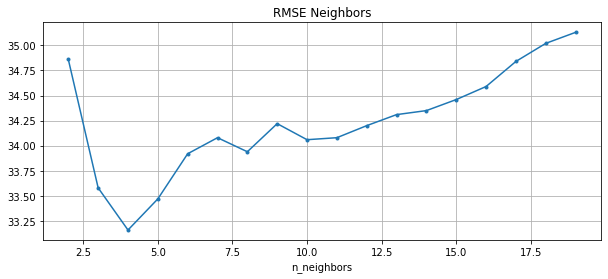

Best RMSE: 33.16
Best params: {'n_neighbors': 4}


In [35]:
train_features, train_target = make_features(train, 25, 10)
model = KNeighborsRegressor()
params = {"n_neighbors": range(2,20)}
grid_hparams(model, params, train_features, train_target, 'Neighbors', True)

Результат между линейной регрессией и случайным лесом

#### LightGBM

IntProgress(value=0)

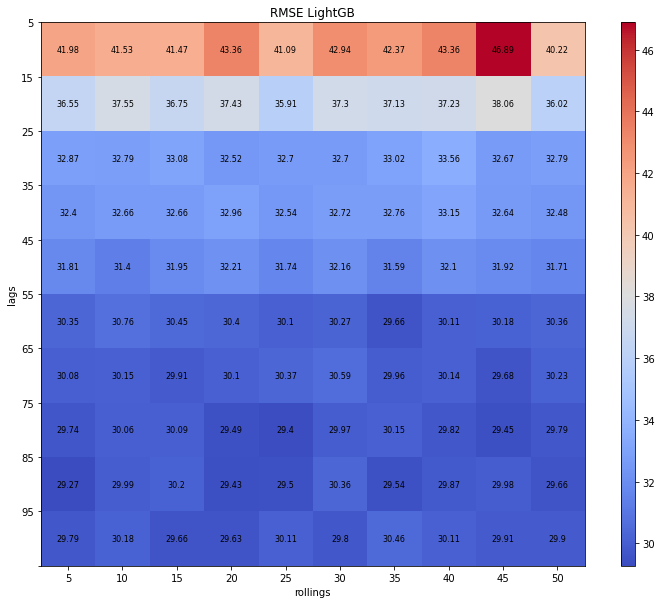

Best RMSE: 29.27
Best params: (85, 5)


In [36]:
model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=123)
lags = range(5,100,10)
rollings = range(5,55,5)
grid_features(model, lags, rollings, 'LightGB')

IntProgress(value=0, max=72)

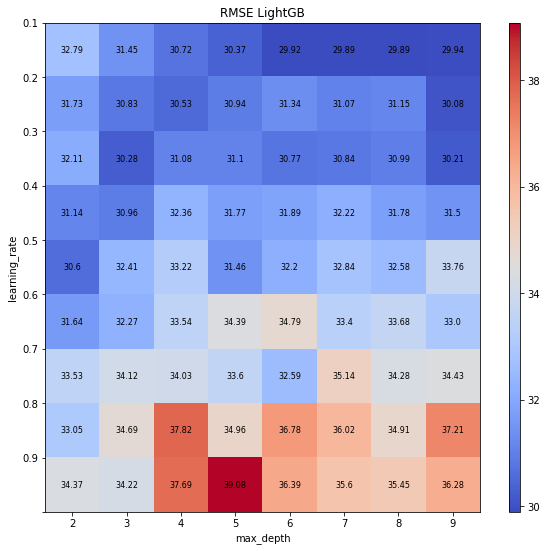

Best RMSE: 29.89
Best params: {'max_depth': 7, 'learning_rate': 0.1}


In [37]:
train_features, train_target = make_features(train, 45, 10)
train_features, valid_features, train_target, valid_target = train_test_split(train_features, train_target, 
                                                                              shuffle=False, test_size=0.1)
model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=123)
params = {'learning_rate': np.arange(0.1, 1, 0.1).round(1), 'max_depth': range(2, 10)}
grid_hparams(model, params, train_features, train_target, 'LightGB', True)

IntProgress(value=0, max=8)

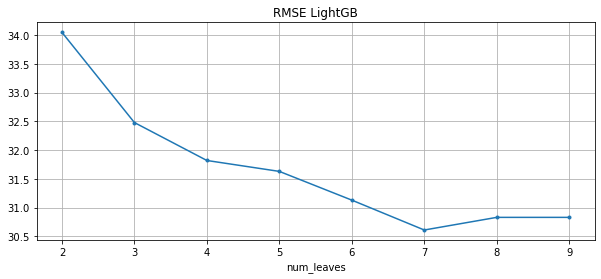

Best RMSE: 30.61
Best params: {'num_leaves': 7}


In [38]:
model = lgb.LGBMRegressor(boosting_type='gbdt', max_depth=3, learning_rate=0.2, random_state=123)
params = {'num_leaves': range(2, 10)}
grid_hparams(model, params, train_features, train_target, 'LightGB', True)

IntProgress(value=0, max=9)

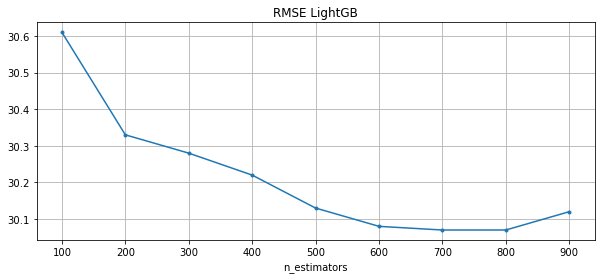

Best RMSE: 30.07
Best params: {'n_estimators': 700}


In [39]:
model = lgb.LGBMRegressor(boosting_type='gbdt', max_depth=3, learning_rate=0.2, num_leaves=7, random_state=123)
params = {'n_estimators': range(100,1000,100)}
grid_hparams(model, params, train_features, train_target, 'LightGB', True)

Получен хороший результат при высокой скорости.

# 4. Тестирование

Посмотрим на таблицу с результатами

In [40]:
model_res

,RMSE
required,48.00
dummy median,87.15
dummy previous,58.86
LinearRegression,31.19
Lasso,31.13
DecisionTree,34.88
RandomForest,32.44
Neighbors,33.16
LightGB,30.07


По результатам валидации лучший результат показала модель LightGBM. Проверим ее на тестовой выборке, использовав подобранные выше признаки и гиперпараметры.

In [50]:
train_features, train_target = make_features(train, 45, 10)
test_features, test_target = make_features(test, 45, 10)
model = lgb.LGBMRegressor(boosting_type='gbdt', max_depth=3, learning_rate=0.2, 
                          num_leaves=7, n_estimators=300, random_state=123)
model.fit(train_features, train_target)
test_prediction = model.predict(test_features)
print('RMSE на тестовой выборке:', rmse(test_target, test_prediction))

RMSE на тестовой выборке: 41.86


Получено значение RMSE 40,44, что удовлетворяет условию. Результат модели лучше, чем у фиктивной, что подтверждает ее адекватность. Сравним распределения реальных и предсказанных данных.

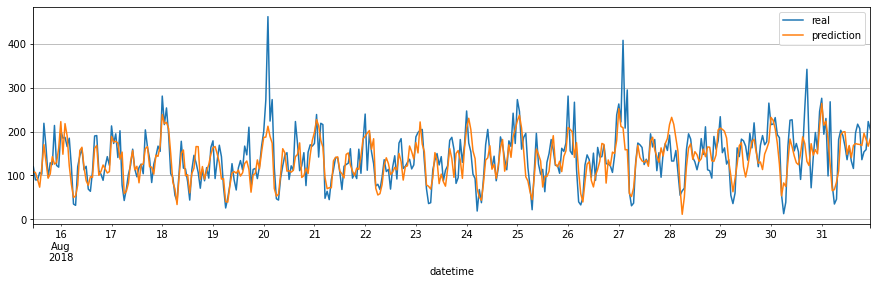

In [42]:
test_res = pd.DataFrame()
test_res['real'] = test_target
test_res['prediction'] = test_prediction

plt.figure(figsize=(15, 4))
test_res.plot(ax=plt.gca())
plt.grid()
plt.show()

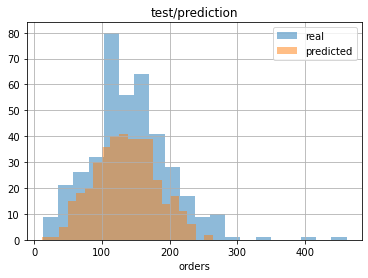

In [43]:
plt.hist(test_target, bins=20, alpha=0.5, label='real')
plt.hist(test_prediction, bins=20, alpha=0.5, label='predicted')
plt.xlabel('orders')
plt.title('test/prediction')
plt.grid()
plt.legend()
plt.show()

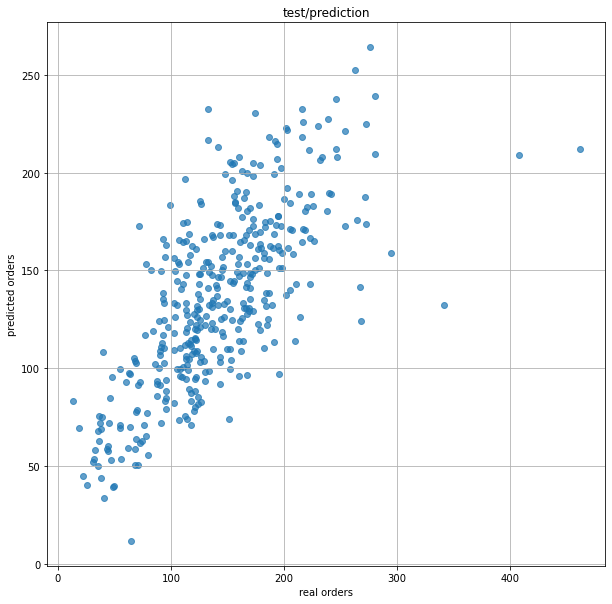

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(test_target, test_prediction, alpha=0.7)
plt.xlabel('real orders')
plt.ylabel('predicted orders')
plt.title('test/prediction')
plt.grid()
plt.show()

Распределения похожи. Модель неплохо предсказывет суточные колебания заказов. При этом предсказание тяготеет к средним значениям, а низкие и высокие значения встречаются в предсказании реже, чем в реальных данных.